This notebook estimates noise levels for each AEM gate.

Neil Symington
neil.symington@ga.gov.au

In [2]:
# Import packages
from sqlite3 import dbapi2 as sqlite
import pandas as pd
from shapely.geometry import Polygon, shape, Point, MultiPoint
import numpy as np
# My own functions developed to work on datasets
from hydrogeol_utils import spatial_functions, AEM_utils
from hydrogeol_utils import plotting_utils as plot_utils
from hydrogeol_utils import borehole_utils, SNMR_utils, grid_utils
# Functions from geophys utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from geophys_utils._netcdf_line_utils import NetCDFLineUtils
from geophys_utils.netcdf_converter import netcdf2aseg_gdf_converter
from geophys_utils import points2convex_hull
import matplotlib.pyplot as plt
import os
import math
import time
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import rasterio
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
from hydrogeol_utils.db_utils import makeCon, closeCon
import numpy.ma as ma

In [3]:
# Open the AEM data file
nc_inpath = r"C:\Users\PCUser\Desktop\AEM\EM\AUS_10021_DalyR_EM.nc"

d = netCDF4.Dataset(nc_inpath, "a")

cond_point_utils = NetCDFPointUtils(d)

In [4]:
d

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Dataset read from ASEG-GDF file AUS_10021_DalyR_EM.dat
    Conventions: CF-1.6,ACDD-1.3
    featureType: trajectory
    geospatial_vertical_min: 2.31
    geospatial_vertical_max: 1178.15
    geospatial_vertical_units: m
    geospatial_vertical_resolution: point
    geospatial_vertical_positive: up
    history: Converted from ASEG-GDF file D:\EFtF_AEM\Daly_River\2017_DalyRiver_SkyTEM\01_EM\AUS_10021_DalyR_EM.dat using definitions file D:\EFtF_AEM\Daly_River\2017_DalyRiver_SkyTEM\01_EM\AUS_10021_DalyR_EM_editted.dfn
    date_created: 2019-11-28T09:02:31.941116
    geospatial_east_resolution: point
    geospatial_north_resolution: point
    geospatial_lon_min: 130.71109008789062
    geospatial_lon_max: 132.80911254882812
    geospatial_lon_units: degrees East
    geospatial_lat_min: -15.268754005432129
    geospatial_lat_max: -13.589241981506348
    geospatial_lat_units: degrees North
    geos

In [5]:
d['rel_uncertainty_low_moment_Z-component']

<class 'netCDF4._netCDF4.Variable'>
float32 rel_uncertainty_low_moment_Z-component(point, low_moment_gate)
    long_name: Z-component Low Moment gates relative uncertainty
    units: fraction
    aseg_gdf_format: 26F11.0
unlimited dimensions: 
current shape = (258660, 18)
filling on, default _FillValue of 9.969209968386869e+36 used

In [7]:
lines = d['line'][:]

In [9]:
# Only interested in lines beginning with 913.. which are high altitude

high_alt_lines = [x for x in lines if x>913000]

highalt_mask = cond_point_utils.get_lookup_mask(high_alt_lines)


In [13]:
runc_quant_hm

array([[0.00052 , 0.00039 , 0.00032 , 0.0003  , 0.00031 , 0.00038 ,
        0.00047 , 0.00056 ,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan],
       [0.00083 , 0.00063 , 0.00052 , 0.00051 , 0.00052 , 0.00065 ,
        0.0008  , 0.00095 ,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan],
       [0.00104 , 0.00079 , 0.00065 , 0.00063 , 0.00065 , 0.00081 ,
        0.00101 , 0.00119 ,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan],
       [0.00128 , 0.00096 , 0.0008  , 0.00077 , 0.00079 , 0.001   ,
        0.00124 , 0.00147 ,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,
       

In [14]:
# Now plot the runc as quantile plots

# low moment

runc_quant_lm = np.nan*np.ones(shape = (10, 18), dtype = np.float32)

for j in range(18):
    print(j)
    runc = d['rel_uncertainty_low_moment_Z-component'][~highalt_mask, j].data
    for i in range(runc_quant_lm.shape[0]):
        runc_quant_lm[i,j] = np.quantile(runc, 0.05 + i*0.1)
    
# high moment

runc_quant_hm = np.nan*np.ones(shape = (10, 23), dtype = np.float32)

for j in range(23):
    print(j)
    runc = d['rel_uncertainty_high_moment_Z-component'][~highalt_mask, j].data
    for i in range(runc_quant_hm.shape[0]):
        runc_quant_hm[i,j] = np.quantile(runc, 0.05 + i*0.1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


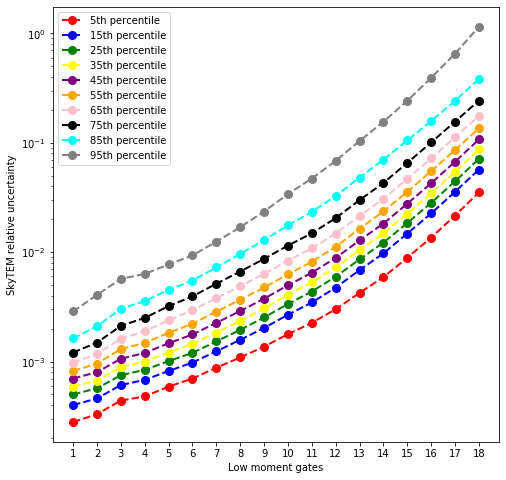

In [15]:
fig, ax= plt.subplots(1,1,figsize = (8,8))

colours = [ "red", "blue", "green", "yellow", "purple", "orange", "pink", "black", "aqua", 'grey']

for i in range(10):
    x = np.arange(1,19)
    ax.plot(x, runc_quant_lm[i,:],
           color=colours[i], marker='o', linestyle='dashed', 
            linewidth=2, markersize=8,
           label = str(5+(10*i)) + "th percentile")
    ax.set_yscale('log')

ax.set_xlabel("Low moment gates")
ax.set_ylabel('SkyTEM relative uncertainty')
ax.set_xticks(x)
ax.legend()
plt.savefig(r"C:\Temp\DR_lm_runc_lineplot.png")
plt.show()

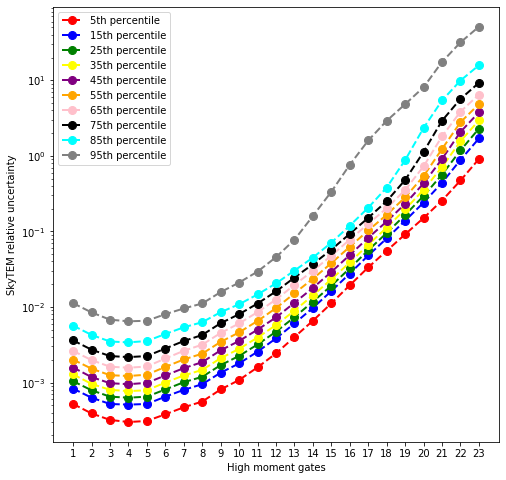

In [16]:
fig, ax= plt.subplots(1,1,figsize = (8,8))

colours = [ "red", "blue", "green", "yellow", "purple", "orange", "pink", "black", "aqua", 'grey']

for i in range(10):
    x = np.arange(1,24)
    ax.plot(x, runc_quant_hm[i,:],
           color=colours[i], marker='o', linestyle='dashed', 
            linewidth=2, markersize=8,
           label = str(5+(10*i)) + "th percentile")
    ax.set_yscale('log')

ax.set_xlabel("High moment gates")
ax.set_ylabel('SkyTEM relative uncertainty')
ax.set_xticks(x)
ax.legend()
plt.savefig(r"C:\Temp\DR_hm_runc_lineplot.png")
plt.show()

In [17]:
# NOw we define our noise levels for the data

# The noise is going to be the square root of sum of the squares of estimates of the
# additive and multiplicative noise

lmmn = 0.03 * d['low_moment_Z-component_EM_data'][:].data
hmmn = 0.03 * d['high_moment_Z-component_EM_data'][:].data

# Additive noise is from the gate-wise standard deviation for the high altitude lines

lman = np.sqrt(np.std(d['low_moment_Z-component_EM_data'][highalt_mask,:].data, axis = 0)**2)
hman = np.sqrt(np.std(d['high_moment_Z-component_EM_data'][highalt_mask,:].data, axis = 0)**2)

# Expand to the same shape as lmmn

lman = np.repeat(lman[np.newaxis,:], lmmn.shape[0], axis=0)
hman = np.repeat(hman[np.newaxis,:], hmmn.shape[0], axis=0)

# Noise is root of some of the squares
lm_noise = np.sqrt(lmmn**2 + lman**2)
hm_noise = np.sqrt(hmmn**2 + hman**2)

# Now divide this by the absolute value of the data to get the relative uncertainty

lm_runc = lm_noise/np.abs(d['low_moment_Z-component_EM_data'][:].data)
hm_runc = hm_noise/np.abs(d['high_moment_Z-component_EM_data'][:].data)


In [18]:
d.dimensions

OrderedDict([('low_moment_gate',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'low_moment_gate', size = 18),
             ('high_moment_gate',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'high_moment_gate', size = 23),
             ('comments',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'comments', size = 3),
             ('line',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'line', size = 167),
             ('flight',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'flight', size = 24),
             ('low_moment_current_time',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'low_moment_current_time', size = 19),
             ('high_moment_current_time',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'high_moment_current_time', size = 15),
             ('gate_open_close',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'gate_open_close', size = 2),
             ('point',
            

In [19]:
# Add the relative uncertainty as a variable


try:
    d.createVariable("recalculated_runc_lm_z","f4",
                               ("point","low_moment_gate"))
    d['recalculated_runc_lm_z'][:] = lm_runc

    d['recalculated_runc_lm_z'].long_name = 'recalculated relative uncertainty for low-moment z-component data'
    
    d['recalculated_runc_lm_z'].formula = "np.sqrt((low-moment multiplicative noise)**2 + (low-moment additive noise)**2)"
except RuntimeError:
    print('Variable exists')

In [20]:
# Add the relative uncertainty as a variable


try:
    d.createVariable("recalculated_runc_hm_z","f4",
                               ("point","high_moment_gate"))
    
    d['recalculated_runc_hm_z'][:] = hm_runc

    d['recalculated_runc_hm_z'].long_name = 'recalculated relative uncertainty for high-moment z-component data'
    
    d['recalculated_runc_hm_z'].formula = "np.sqrt((high-moment multiplicative noise)**2 + (high-moment additive noise)**2)"

except RuntimeError:
    print('Variable exists')

In [21]:
# Now plot the runc as quantile plots

# low moment

runc_quant_lm = np.nan*np.ones(shape = (10, 18), dtype = np.float32)

for j in range(18):
    runc = lm_noise[~highalt_mask,j]/np.abs(d['low_moment_Z-component_EM_data'][~highalt_mask, j])
    for i in range(runc_quant_lm.shape[0]):
        runc_quant_lm[i,j] = np.quantile(runc, 0.05 + i*0.1)
    
# high moment

runc_quant_hm = np.nan*np.ones(shape = (10, 23), dtype = np.float32)

for j in range(23):
    runc = hm_noise[~highalt_mask,j]/np.abs(d['high_moment_Z-component_EM_data'][~highalt_mask,j])
    for i in range(runc_quant_hm.shape[0]):
        runc_quant_hm[i,j] = np.quantile(runc, 0.05 + i*0.1)

In [22]:
# Add the relative uncertainty as a variable


try:
    d.createVariable("lm_z_noise","f4",
                               ("point","low_moment_gate"))
    d['lm_z_noise'][:] = lm_noise

    d['lm_z_noise'].long_name = 'lm_Z-component_noise'
    
    d['lm_z_noise'].formula = "np.sqrt((low-moment multiplicative noise)**2 + (low-moment additive noise)**2)"
except RuntimeError:
    print('Variable exists')

In [23]:
# Add the relative uncertainty as a variable


try:
    d.createVariable("hm_z_noise","f4",
                               ("point","high_moment_gate"))
    d['hm_z_noise'][:] = hm_noise

    d['hm_z_noise'].long_name = 'hm_Z-component_noise'
    
    d['hm_z_noise'].formula = "np.sqrt((high-moment multiplicative noise)**2 + (high-moment additive noise)**2)"
except RuntimeError:
    print('Variable exists')

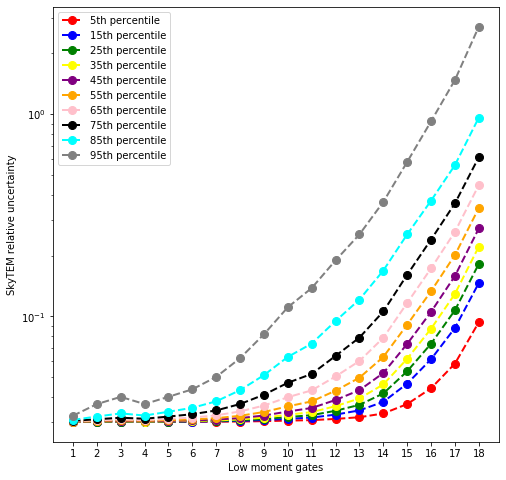

In [24]:
fig, ax= plt.subplots(1,1,figsize = (8,8))

colours = [ "red", "blue", "green", "yellow", "purple",
           "orange", "pink", "black", "aqua", 'grey']

for i in range(10):
    x = np.arange(1,19)
    ax.plot(x, runc_quant_lm[i,:],
           color=colours[i], marker='o', linestyle='dashed', 
            linewidth=2, markersize=8,
           label = str(5+(10*i)) + "th percentile")
    ax.set_yscale('log')

ax.set_xlabel("Low moment gates")
ax.set_ylabel('SkyTEM relative uncertainty')
ax.set_xticks(x)
ax.legend()
plt.savefig(r"C:\Temp\DR_lm_Ross_noise_runc_lineplot.png")
plt.show()

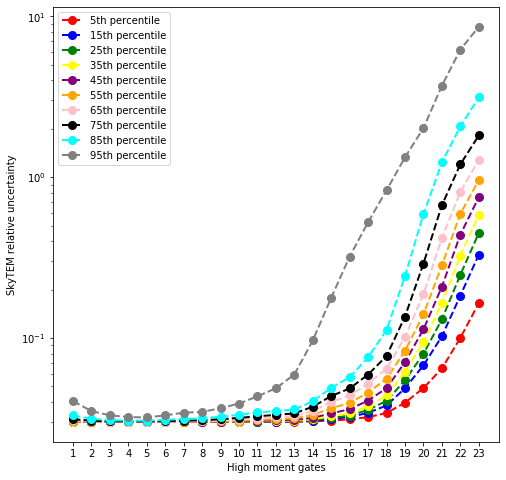

In [25]:
fig, ax= plt.subplots(1,1,figsize = (8,8))

colours = [ "red", "blue", "green", "yellow", "purple",
           "orange", "pink", "black", "aqua", 'grey']

for i in range(10):
    x = np.arange(1,24)
    ax.plot(x, runc_quant_hm[i,:],
           color=colours[i], marker='o', linestyle='dashed', 
            linewidth=2, markersize=8,
           label = str(5+(10*i)) + "th percentile")
    ax.set_yscale('log')

ax.set_xlabel("High moment gates")
ax.set_ylabel('SkyTEM relative uncertainty')
ax.set_xticks(x)
ax.legend()
plt.savefig(r"C:\Temp\DR_hm_Ross_noise_runc_lineplot.png")
plt.show()

In [26]:
# Now we want to plot negative transients vs noise as a scatte plot

# low moment

lm_dat = d['low_moment_Z-component_EM_data'][~highalt_mask, :].data

neg_transient_mask = np.where(lm_dat < 0)

dat = lm_dat[neg_transient_mask]

noise = lm_noise[neg_transient_mask]



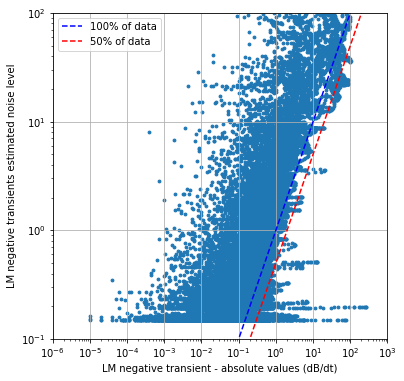

In [27]:

fig, ax = plt.subplots(1,1, figsize = (6,6))



ax.plot([10**-2,10**3],[10**-2,10**3],
       label = '100% of data', color = 'blue',
             linestyle='dashed')

ax.plot([10**-2,10**3],[.5*10**-2,.5*10**3],
       label = '50% of data', color = 'red',
             linestyle='dashed')
ax.scatter(np.abs(dat), noise, s = 8)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(10**-6, 10**3)
ax.set_ylim(10**-1, 10**2)
ax.set_xlabel('LM negative transient - absolute values (dB/dt)')
ax.set_ylabel('LM negative transients estimated noise level')
ax.grid(True, which = 'major')

ax.legend()
plt.savefig(r"C:\Temp\DR_lm_abs_neg_transient_vs_Ross_noise.png")
plt.show()

In [28]:
# high moment

hm_dat = d['high_moment_Z-component_EM_data'][~highalt_mask, :].data

neg_transient_mask = np.where(hm_dat < 0)

dat = hm_dat[neg_transient_mask]

noise = hm_noise[neg_transient_mask]


In [29]:
np.max(lm_dat)

30712.648

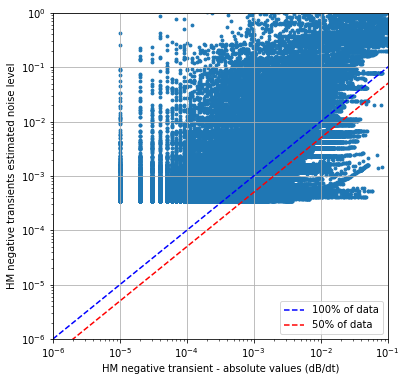

In [30]:

fig, ax = plt.subplots(1,1, figsize = (6,6))



ax.plot([10**-6,10**0],[10**-6,10**0],
       label = '100% of data', color = 'blue',
             linestyle='dashed')

ax.plot([10**-6,10**0],[.5*10**-6,.5*10**0],
       label = '50% of data', color = 'red',
             linestyle='dashed')
ax.scatter(np.abs(dat), noise, s = 8)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(10**-6, 10**-1)
ax.set_ylim(10**-6, 10**0)
ax.set_xlabel('HM negative transient - absolute values (dB/dt)')
ax.set_ylabel('HM negative transients estimated noise level')
ax.grid(True, which = 'major')

ax.legend()
plt.savefig(r"C:\Temp\DR_hm_abs_neg_transient_vs_Ross_noise.png")
plt.show()

In [31]:
np.min(d['easting'])

684724.44

In [33]:
d.close()

RuntimeError: NetCDF: Not a valid ID